In [64]:
from doctest import testfile

import numpy as np
import matplotlib.pyplot as plt

## CODIFICADOR

In [65]:
bits = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
SF = 7
SF_Validos = [7, 8, 9, 10, 11, 12]

def coder(bits, SF):
    #Verificar si SF es valido
    if SF not in SF_Validos:
        raise ValueError("Invalido")
    #Verificar que la cantidad de bits sea multiplo del SF
    if len(bits) % SF != 0:
        raise ValueError("Numero de bits no es multiplo de SF")

       # Inicialización del vector de símbolos
    N_simbolos = len(bits) // SF
    s = np.zeros(N_simbolos, dtype=int)

    # Implementación de la ecuación (1)
    for i in range(N_simbolos):
        for h in range(SF):
            s[i] += bits[i * SF + h] * (2 ** h)

    return s

print(coder(bits, SF))

[57 20]


###  Ejemplo de codificación usando la Ecuación (1)

#### Datos de entrada:

- `bits = [1, 0, 0, 1, 1, 1, 0]`
- `SF = 7`

#### Desarrollo paso a paso:

Agrupamos los 7 bits como un único símbolo, ya que `SF = 7`.

$\begin{aligned}
s &= w_0 \cdot 2^0 + w_1 \cdot 2^1 + w_2 \cdot 2^2 + w_3 \cdot 2^3 + w_4 \cdot 2^4 + w_5 \cdot 2^5 + w_6 \cdot 2^6 \\
  &= 1 \cdot 2^0 + 0 \cdot 2^1 + 0 \cdot 2^2 + 1 \cdot 2^3 + 1 \cdot 2^4 + 1 \cdot 2^5 + 0 \cdot 2^6 \\
  &= 1 \cdot 1 + 0 \cdot 2 + 0 \cdot 4 + 1 \cdot 8 + 1 \cdot 16 + 1 \cdot 32 + 0 \cdot 64 \\
  &= 1 + 0 + 0 + 8 + 16 + 32 + 0 \\
  &= 57
\end{aligned}$


####  Resultado esperado:

```python
[57]


## DECODIFICADOR

In [66]:
def decoder(s, SF):
    # Verificar que SF sea válido
    if SF not in SF_Validos:
        raise ValueError("SF inválido")

    bits_recuperados = []

    # Por cada símbolo, reconstruir los SF bits
    for simbolo in s:
        #bits_simbolos=[]
        for h in range(SF):
            # Obtener el bit de orden h (menos significativo primero)
            bit = (simbolo >> h) & 1
            bits_recuperados.append(bit)
        #bits_recuperados.append(bits_simbolos)

    return bits_recuperados
print(decoder([57], 7))

[1, 0, 0, 1, 1, 1, 0]


### Decodificación manual del símbolo (Ecuación inversa de la codificación)

#### Dato recibido:

- Símbolo codificado: `s = 57`
- Spreading Factor: `SF = 7`

Queremos obtener los 7 bits originales que generaron este símbolo.


#### Desarrollo paso a paso:

| h (posición del bit) | Cálculo                          | Resultado `w_h` |
|----------------------|----------------------------------|-----------------|
| 0                    | \( (57 >> 0) \& 1 = 57 \& 1 \)   | 1               |
| 1                    | \( (57 >> 1) \& 1 = 28 \& 1 \)   | 0               |
| 2                    | \( (57 >> 2) \& 1 = 14 \& 1 \)   | 0               |
| 3                    | \( (57 >> 3) \& 1 = 7 \& 1 \)    | 1               |
| 4                    | \( (57 >> 4) \& 1 = 3 \& 1 \)    | 1               |
| 5                    | \( (57 >> 5) \& 1 = 1 \& 1 \)    | 1               |
| 6                    | \( (57 >> 6) \& 1 = 0 \& 1 \)    | 0               |



In [67]:
bit_randoms=np.random.randint(0,2,14)
Codificador = coder(bit_randoms, 7)
Decodificados = decoder(Codificador, 7)

def errores(lista1, lista2):

    error=0
    for i,j in zip(lista1, lista2):
        if (i != j):
            error+=1
    return error

def ber(bits_tx,bits_rx):
    BER=errores(bits_tx,bits_rx)/len(bit_randoms)
    return BER

print(ber(bit_randoms,Decodificados))

0.0


### Waveformer Former

In [68]:

def waveform_former(s, SF):
    M = 2 ** SF  # cantidad de muestras por chirp
    chirps = []

    for simbolo in s:
        k = np.arange(M)
        fase = ((simbolo + k) % M) * k / M
        chirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
        chirps.append(chirp)

    return np.array(chirps)  # matriz [N x M]




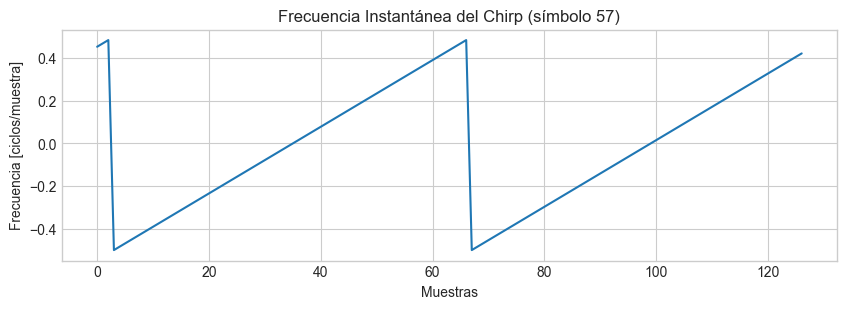

In [69]:

 # Generar un chirp para símbolo 57
chirp = waveform_former([57], SF)[0]

# Calcular fase y frecuencia instantánea
fase = np.unwrap(np.angle(chirp))
frecuencia_inst = np.diff(fase) / (2 * np.pi)

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(frecuencia_inst)
plt.title("Frecuencia Instantánea del Chirp (símbolo 57)")
plt.xlabel("Muestras")
plt.ylabel("Frecuencia [ciclos/muestra]")
plt.grid(True)
plt.show()

##  Waveform Former

###  Ecuación (2) del paper de Vangelista

La señal modulada transmitida para un símbolo $\begin{aligned}( s(nT_s) \in \{0, 1, \dots, 2^{SF} - 1\}) \end{aligned}$, según la Ecuación (2) del paper, se define como:



$\begin{aligned}
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi \cdot \left[ \frac{(s(nT_s) + k) \bmod 2^{SF} \cdot k}{2^{SF}} \right]}
\quad \text{para } k = 0, 1, \dots, 2^{SF}-1
\end{aligned}$

Donde:
- $\begin{aligned} SF \end{aligned}$: Spreading Factor.
- $\begin{aligned} s(nT_s)\end{aligned}$: símbolo entero codificado (de 0 a \(2^{SF}-1\)).
- $\begin{aligned} k \end{aligned}$: índice de muestra temporal (discreto).
- $\begin{aligned} c(nT_s + kT) \end{aligned}$: muestra compleja de la forma de onda LoRa transmitida.

Esta señal es un "chirp" modulado en frecuencia, cuya frecuencia instantánea varía linealmente.




### n-Tuple Former

In [70]:
def n_tuple_former(received_chirps, SF):
    M = 2 ** SF
    k = np.arange(M)
    downchirp =  np.exp(-1j * 2 * np.pi * k**2 / M)

    simbolos_estimados = []
    for chirp in received_chirps:
        producto = chirp * downchirp
        fft_producto = np.fft.fft(producto) #Es la Transformada Rápida de Fourier (FFT) en NumPy
        simbolo_estimado = np.argmax(np.abs(fft_producto))
        simbolos_estimados.append(simbolo_estimado)

    return np.array(simbolos_estimados)


##  n-Tuple Former — Receptor Óptimo

###  Descripción Teórica (Sección III del paper de Vangelista)

La detección del símbolo transmitido se realiza aplicando un correlador discreto implementado como un receptor óptimo (n-Tuple Former). El procedimiento consiste en:

1. Multiplicar el chirp recibido por una señal conjugada de referencia conocida como "downchirp":
   $\begin{aligned}
   d(k) = e^{-j2\pi \cdot \frac{k^2}{2^{SF}}}
   \end{aligned}$
2. Aplicar una Transformada Rápida de Fourier (FFT) al producto.
3. Detectar el símbolo como el índice del valor máximo del espectro resultante.


###  Análisis Matemático

Para cada chirp recibido $\begin{aligned} r(k) \end{aligned}$, se realiza:

$\begin{aligned}
d(k) &= r(k) \cdot e^{-j2\pi \cdot \frac{k^2}{2^{SF}}} \\
R(f) &= \text{FFT}\left\{ d(k) \right\} \\
\hat{s} &= \arg \max_{f} \left| R(f) \right|
\end{aligned}$

Donde:
- $\begin{aligned} r(k) \end{aligned}$: chirp recibido de longitud $\begin{aligned} M = 2^{SF} \end{aligned}$
- $\begin{aligned} d(k) \end{aligned}$: señal desmodulada en base al downchirp
- $\begin{aligned} R(f) \end{aligned}$: transformada espectral
- $\begin{aligned} \hat{s} \end{aligned}$: símbolo estimado

Este proceso actúa como un **correlador en frecuencia**, donde cada símbolo posible produce un pico en una posición distinta del espectro. El símbolo transmitido es el que **mejor correlaciona** con el chirp recibido.



In [71]:
# Definimos funciones de utilidad
def errores_simbolos(s_tx, s_rx):
    #Cuenta cuántos símbolos difieren entre dos listas
    error = 0
    for i, j in zip(s_tx, s_rx):
        if i != j:
            error += 1
    return error

def ser(s_tx, s_rx):
    #
    return errores_simbolos(s_tx, s_rx) / len(s_tx)


In [72]:

bit_randoms = np.random.randint(0, 2, SF * 2)  # 2 símbolos

# Transmisor
s_tx = coder(bit_randoms, SF)
chirps_tx = waveform_former(s_tx, SF)

# Receptor (sin canal)
s_rx = n_tuple_former(chirps_tx, SF)

# Calcular SER
print("Símbolos transmitidos:", s_tx[:10])
print("Símbolos decodificados:", s_rx[:10])
print("SER:", ser(s_tx, s_rx))

Símbolos transmitidos: [23 97]
Símbolos decodificados: [23 97]
SER: 0.0


Símbolo transmitido: 57
Símbolo detectado : 57


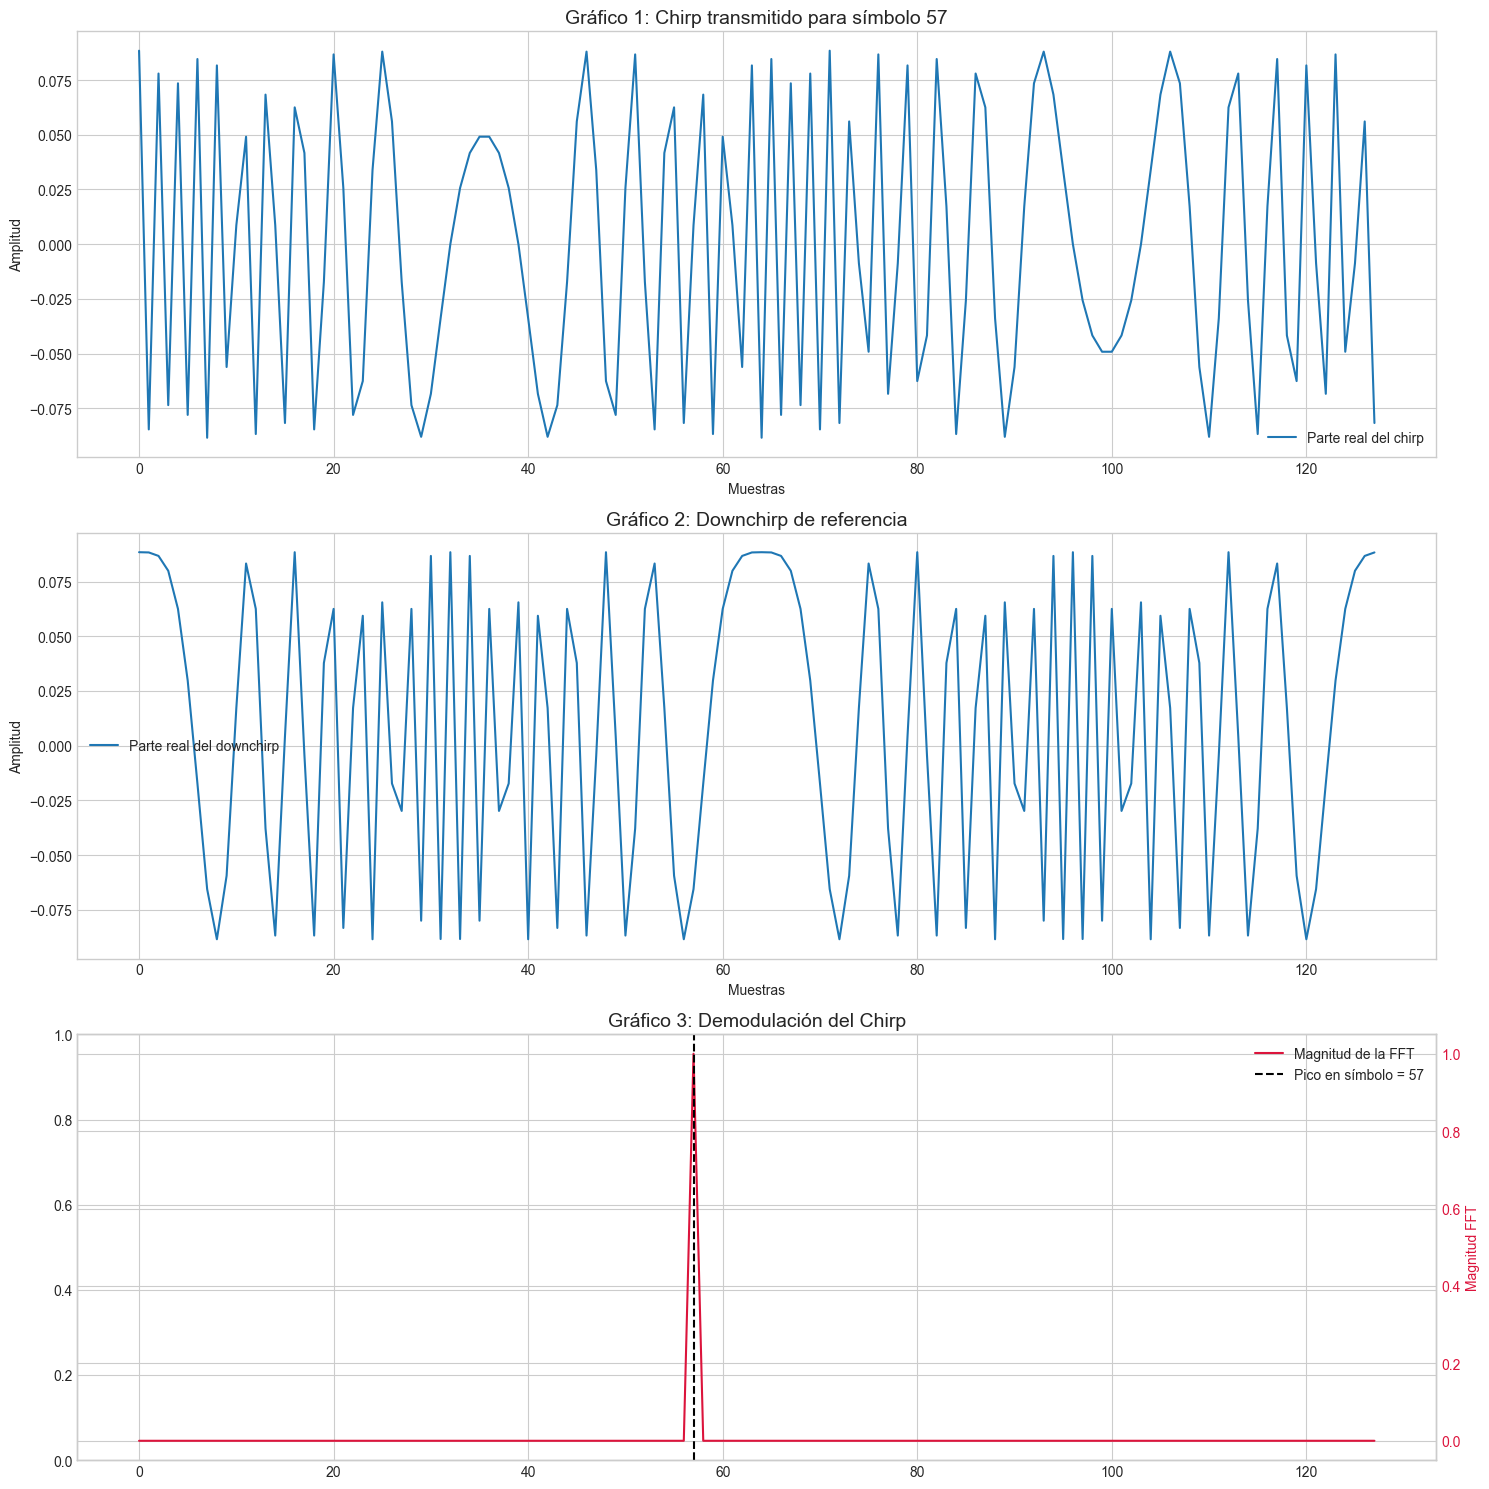

In [73]:
# === Transmisión de un solo símbolo ===
chirp_tx = waveform_former([simbolo_tx], SF)[0]
downchirp = (1 / np.sqrt(M)) * np.exp(-1j * 2 * np.pi * np.arange(M)**2 / M)
simbolo_rx = n_tuple_former([chirp_tx], SF)[0]

print(f"Símbolo transmitido: {simbolo_tx}")
print(f"Símbolo detectado : {simbolo_rx}")

# === GRAFICAMOS ===
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 15))

# --- Gráfico 1: Chirp transmitido ---
plt.subplot(3, 1, 1)
plt.plot(np.real(chirp_tx), label='Parte real del chirp')
plt.title(f'Gráfico 1: Chirp transmitido para símbolo {simbolo_tx}', fontsize=14)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# --- Gráfico 2: Downchirp de referencia ---
plt.subplot(3, 1, 2)
plt.plot(np.real(downchirp), label='Parte real del downchirp')
plt.title('Gráfico 2: Downchirp de referencia', fontsize=14)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# --- Gráfico 3: Demodulación del chirp ---
plt.subplot(3, 1, 3)
producto = chirp_tx * downchirp
fft_mag = np.abs(np.fft.fft(producto))

ax1 = plt.gca()

ax2 = ax1.twinx()
ax2.plot(fft_mag, color='crimson', label='Magnitud de la FFT')
ax2.axvline(x=simbolo_rx, color='k', linestyle='--', label=f'Pico en símbolo = {simbolo_rx}')
ax2.set_ylabel('Magnitud FFT', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.legend(loc='upper right')

plt.title('Gráfico 3: Demodulación del Chirp', fontsize=14)
plt.tight_layout()
plt.show()

### Implementación del ruido AWGN

In [74]:
def energia_promedio_chirp(chirps):
     return np.mean(np.abs(chirps)**2)

In [78]:
def agregar_ruido_AWGN(chirps, SNR_dB):
    #M = chirps.shape[1]  # cantidad de muestras por chirp
    SNR_linear = 10**(SNR_dB / 10)

    Es = energia_promedio_chirp(chirps)
    sigma2 = Es / SNR_linear

    ruido = np.sqrt(sigma2) * (np.random.randn(*chirps.shape) + 1j * np.random.randn(*chirps.shape))
    return chirps + ruido

##  Canal con Ruido AWGN y Curva BER/SER

### AWGN (Additive White Gaussian Noise)
Según la Sección IV del paper, el sistema puede ser evaluado bajo un modelo de canal con ruido aditivo blanco gaussiano complejo (AWGN).
Es un modelo de canal donde el ruido se suma a la señal transmitida:
- Media: 0
- Varianza: $\begin{aligned} \sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}\end{aligned}$


Donde:

$\begin{aligned}
\text{SNR}_{\text{linear}} = 10^{\frac{\text{SNR}_{dB}}{10}}, \quad
\sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}
\end{aligned}$



### Procedimiento:
1. Se genera una señal chirp (modulada) por símbolo.
2. Se suma ruido Gaussiano complejo a la señal transmitida.
3. Se decodifica usando n-Tuple Former + FFT.
4. Se comparan los símbolos y bits originales con los decodificados.
5. Se calcula y grafica:
   - BER: tasa de error de bit.
   - SER: tasa de error de símbolo.

In [76]:
def canal_selectivo_frecuencia(chirps, SF):
    M = 2 ** SF  # muestras por chirp
    h = np.zeros(2 * M, dtype=complex)
    h[0] = np.sqrt(0.85)
    h[M] = np.sqrt(0.2)  # retardo de 1 chirp = M muestras

    # Aplicamos la convolución a cada chirp por separado, pero concatenamos en el tiempo
    signal = chirps.flatten()
    signal_filtrada = np.convolve(signal, h, mode='full')

    # Repartimos nuevamente en chirps (ignoramos el primer símbolo que queda corrupto)
    N = len(chirps)
    chirps_out = np.zeros_like(chirps, dtype=complex)

    for i in range(1, N):  # empieza en 1 porque el primer símbolo se contamina con el retardo
        inicio = i * M
        chirps_out[i] = signal_filtrada[inicio : inicio + M]

    return chirps_out[1:]  # se descarta el primer símbolo (interferido por el retardo)

## Canal Selectivo en Frecuencia


En la Sección IV del paper de Vangelista, se modela un canal selectivo en frecuencia mediante una respuesta al impulso discreta definida como:

$\begin{aligned}
h(nT) = \sqrt{0.85} \cdot \delta(nT) + \sqrt{0.2} \cdot \delta(nT - T)
\end{aligned}$

Este canal tiene dos trayectorias:

- Una trayectoria directa con ganancia $\begin{aligned} \sqrt{0.85} \end{aligned}$ y sin retardo.
- Una trayectoria secundaria con ganancia $\begin{aligned} \sqrt{0.2} \end{aligned}$ y un retardo de $\begin{aligned} T \end{aligned}$, es decir, de una duración completa de chirp.

Dado que cada chirp tiene $\begin{aligned} M = 2^{\text{SF}} \end{aligned}$ muestras, se implementa el canal como una convolución discreta entre la señal transmitida y un vector $\begin{aligned} h \end{aligned}$ con dos picos:

$\begin{aligned}
h[n] =
\begin{cases}
\sqrt{0.85}, & n = 0 \\
\sqrt{0.2}, & n = M \\
0, & \text{en otro caso}
\end{cases}
\end{aligned}$

La función canal_selectivo_frecuencia(chirps, SF) realiza lo siguiente:

1. Construye la respuesta impulsiva del canal $\begin{aligned} h[n] \end{aligned}$ como un vector complejo de longitud $\begin{aligned} 2M \end{aligned}$, colocando los valores no nulos en las posiciones $\begin{aligned} 0 \end{aligned}$ y $\begin{aligned} M \end{aligned}$.

2. Concatena los chirps** (que originalmente están separados en una matriz) en un único vector 1D con `flatten()`, para simular la transmisión continua por el canal.

3. Aplica la convolución** de la señal concatenada con $\begin{aligned} h[n] \), lo que introduce interferencia entre chirps consecutivos debido al retardo.

4. Re-ensambla los chirps** desde la señal filtrada, ignorando el primer chirp porque está contaminado por el retardo de la trayectoria secundaria.

5. Devuelve la salida a partir del segundo chirp, ya que es el primero no afectado por el retardo de otro símbolo anterior.

Este modelo permite simular los efectos de dispersión temporal (ISI) característicos de un canal selectivo en frecuencia, y es fundamental para reproducir la curva etiquetada como "Freq. Sel. FSCM" en la Figura 4 del paper de referencia.


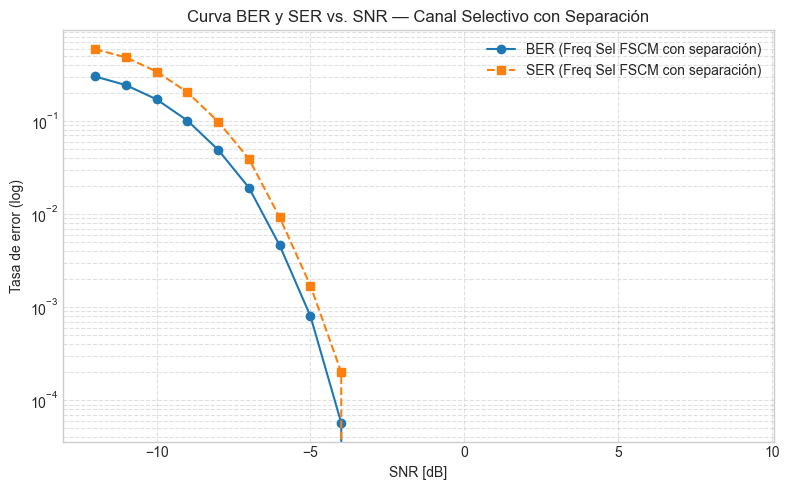

In [79]:

N_SIMBOLOS = 10000
SNR_dBs = np.arange(-12, 10, 1)
BERs, SERs = [], []

# 1. Bits y codificación
bit_randoms = np.random.randint(0, 2, SF * N_SIMBOLOS)
s_tx = coder(bit_randoms, SF)
chirps_tx = waveform_former(s_tx, SF)

# 2. SEPARACIÓN entre chirps para evitar interferencia
chirps_sep = np.zeros((2 * len(chirps_tx), M), dtype=complex)
chirps_sep[::2] = chirps_tx  # chirps en posiciones pares

# 3. Canal selectivo en frecuencia
chirps_filtrados = canal_selectivo_frecuencia(chirps_sep, SF)

# 4. Nos quedamos con los chirps útiles (sin los intermedios ni el primero)
chirps_utiles = chirps_filtrados[::2]  # recuperar solo chirps válidos
s_tx_util = s_tx[1:]  # se pierde el primero por el canal
bits_tx_util = bit_randoms[SF:]

# 5. Simulación sobre SNRs
for SNR in SNR_dBs:
    chirps_noisy = agregar_ruido_AWGN(chirps_utiles, SNR)
    s_rx = n_tuple_former(chirps_noisy, SF)
    s_rx = s_rx[1:]  # se pierde un chirp más
    bits_rx = decoder(s_rx, SF)

    BERs.append(ber(bits_tx_util, bits_rx))
    SERs.append(ser(s_tx_util, s_rx))


# ============================
# GRÁFICO FINAL
# ============================

plt.figure(figsize=(8, 5))
plt.semilogy(SNR_dBs, BERs, 'o-', label='BER (Freq Sel FSCM con separación)')
plt.semilogy(SNR_dBs, SERs, 's--', label='SER (Freq Sel FSCM con separación)')
plt.xlabel("SNR [dB]")
plt.ylabel("Tasa de error (log)")
plt.title("Curva BER y SER vs. SNR — Canal Selectivo con Separación")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()